# Fourier Transforms Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib
from scipy.signal import find_peaks


%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(10,6)})

## Discrete Fourier Transform (DFT)

$$S[m] = \sum_{n=0}^{N-1} s[n] e^{-i 2 \pi m \left({\frac{n}{N}}\right) }$$

Write a function that computes the DFT of a 1D arraay.

In [2]:
def DFT_slow(s):
    """
    Compute the discrete Fourier Transform of the 1D array x
    :param s: (array)
    """
    
    ## YOUR CODE HERE
    
    N=len(s)
    x = np.ndarray(N, dtype=np.complex_)
    x.fill(1)
    rou = np.ndarray(N, dtype=np.complex_)
    for i in range(N):
        rou[i] = np.exp(-2j*np.pi*i/N)
    f = np.ndarray(N, dtype=np.complex_)
    for i in range(N):
        f[i] = np.dot(x, s)
        x *= rou
    return f
print(DFT_slow([1,3,9,27]))

[ 40.+0.00000000e+00j  -8.+2.40000000e+01j -20.-8.08266887e-15j
  -8.-2.40000000e+01j]


If you have extra time try writing a function that also computes the DFT but by using the dot product (recall the dot product sums over the element-wise products).

In [3]:
print(np.fft.fft([1,3,9,27]))

def FFT(s):
    """
    Compute the discrete Fourier Transform of the 1D array x
    :param s: (array)
    """
    L = 0
    while(1<<L < len(s)): L += 1
    assert(len(s) == 1 << L)
    if(L == 0):
        return s
    
    a_even = np.ndarray(1<<L-1, dtype=np.complex_)
    a_odd  = np.ndarray(1<<L-1, dtype=np.complex_)
    for i in range(1<<L-1):
        a_even[i] = s[i<<1]
        a_odd[i] = s[i<<1|1]
    a_even = FFT(a_even)
    a_odd = FFT(a_odd)
    f = np.ndarray(1<<L, dtype=np.complex_)
    for i in range(1<<L-1):
        d = a_odd[i] * np.exp(-2j*np.pi*i/(1<<L))
        f[i] = a_even[i] + d
        f[1<<L-1|i] = a_even[i] - d
    return f
    ## YOUR CODE HERE
    
# print(FFT([1,3,9,27]))

def FFT2(s):
    L = 0
    while(1<<L < len(s)): L += 1
    assert(len(s) == 1 << L)
    
    f = np.ndarray(1<<L, dtype=np.complex_)
    for i in range(1<<L): # Partition
        x=0
        for j in range(L):
            if(i>>j&1):
                x|=1<<L-j-1
        f[x] = s[i]
    rou = np.exp(-2j*np.pi*np.arange(1<<L)/(1<<L))
    for l in range(L): # Divide & Conquer
        for i in range(0, 1<<L, 1<<l+1):
            for j in range(1<<l):
                d = rou[j<<L-l-1]*f[i+(j|1<<l)]
                # d = f[i+(j|1<<l)] * np.exp(-2j*np.pi*j/(1<<l+1));
                f[i+(j|1<<l)] = f[i+j]-d
                f[i+j] += d
        # print("DBG", f)
    return f

# print(FFT2([1,3,9,27]))


[ 40. +0.j  -8.+24.j -20. +0.j  -8.-24.j]


Below is an example signal constructed to test out both your DFT functions

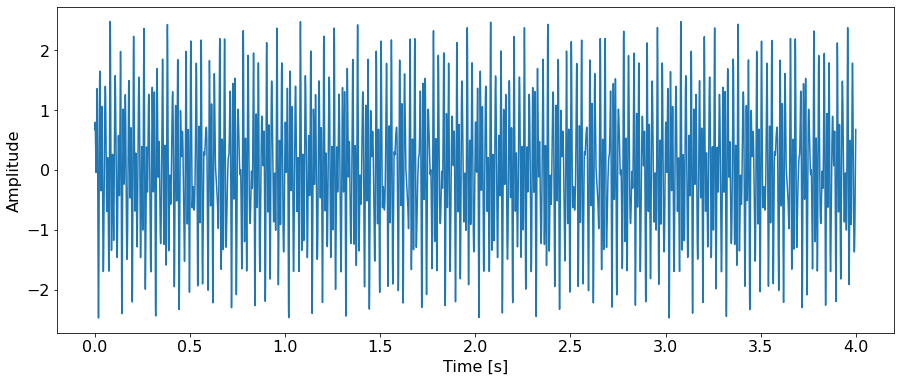

In [4]:
num_sec = 4         # sampling period (in seconds)
num_pts = 1<<11       # samples per second


# make a complex signal with two sinusoids to test both of your DFT calculation methods
t = np.linspace(0, num_sec, num_pts*num_sec)
s = np.sin(40 * 2 * np.pi * t) + 0.5 * np.sin(90 * 2 * np.pi * t) + np.sin(73 * 2 * np.pi * t + 2.4)

plt.figure(figsize=(15,6))
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()

In [5]:
Fs = 1/(t[1] - t[0])     # sample rate
print("Sample Rate:", Fs)
N = s.size               # number of samples (length of signal)

k = np.arange(N)         # frequncy bins
T = N/Fs                 # frequency interval of a single bin
frq = k/T                # two sides frequency range
frq = frq[range(N//2)]   # one side frequency range (Fourier transform outputs symmetric frequencies)

Sample Rate: 2047.75


### Perform Fourier Transform on the signal defined above using both of your DFT functions and numpy's fft

Perform a DFT on the example signal created above. As a bonus, time how long it takes for each method to run and compare them! (You can use the time module, i.e. "import time".)

In [7]:
# Perform Fourier Transform using your function DFT() and numpy's fft

## YOUR CODE HERE

import time

start = time.time()
y_slow = DFT_slow(s)
print("SLOW DFT", time.time()-start)
# start = time.time()
# y_dq = FFT(s)
# print("DQ FFT", time.time()-start)
# start = time.time()
# y_it = FFT2(s)
# print("IT FFT", time.time()-start)
start = time.time()
y_np = np.fft.fft(s)
print("NP FFT", time.time()-start)


SLOW DFT 0.42232418060302734
NP FFT 0.0009338855743408203


## Plot the Frequency Spectrum

Plot the frequency spectrum from using your DFT function(s) and numpy's fft. They should all come out the same.

Note that when we plot a DFT we take the absolute value of the value returned from the fft. (The raw value returned by the fft has both real and imaginary components. When we take its absolute value we are calculating the magnitude of the sine waves that make up the original signal and ignoring their phases.) Also, we often only plot the first half of the fft. This is because when we take the fft of a completely real signal, the second half of the fft is just the complex conjugate of the first half, and thus redundant.

In [8]:
def plot_FT(ft, T, N, flipxy=False):
    """
    plot the Fourier Transform frequency spectrum
    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    :param T: sample resolution (in seconds)
    :param N: total number of samples

    Note: only plot the first 1/2 of what the FT returns 
    (the other half is just the complex congugate)

    """




    if not flipxy:
        ## YOUR CODE HERE
        plt.plot(np.arange(N//2)/(N*T), np.abs(ft[:N//2]))

    else:
    # sometimes we may want to plot on flipped x/y axis
        ## yOUR CODE HERE
        plt.plot(np.abs(ft[:N//2]), np.arange(N//2)/(N*T))
  

[160 292 360]
[39.99511719 72.99108887 89.98901367]


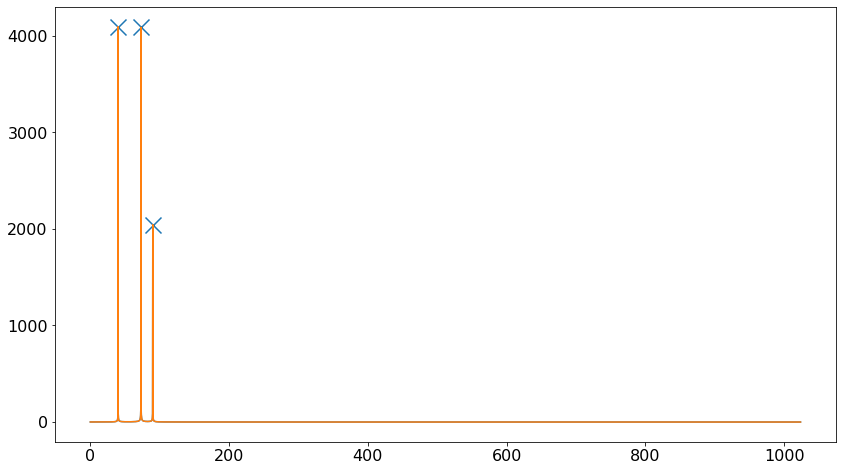

In [9]:
# plot using the above function you just defined and np.fft.fft to ensure they provide the same answer

T = t[1] - t[0]  # sample rate
N = len(s)

plt.figure(figsize=(14,8))
plot_FT(np.fft.fft(s), T, N, False)
my_res = FFT(s)
plot_FT(my_res, T, N, False)

peaks = find_peaks(np.abs(my_res[:N//2]), height=1000)
print(peaks[0])

plt.scatter(peaks[0]/(N*T), peaks[1]['peak_heights'], marker='x', s=256)
print(peaks[0]/(N*T))

plt.show()


## YOUR CODE HERE

## Inverse Fourier Transform (IFT)

Let's try a more complicated signal.

Try taking the FFT of the ecg signal (you can use np.fft.fft) and plot it next to the time-domain signal. Can you identify any peaks in the fft corresponding to repeating structures in the ecg? (You might need to zoom into the x-axis.)

Also, use the ifft function (np.fft.ifft) to reproduce the time-domain signal again from the fft and verify it matches the original.

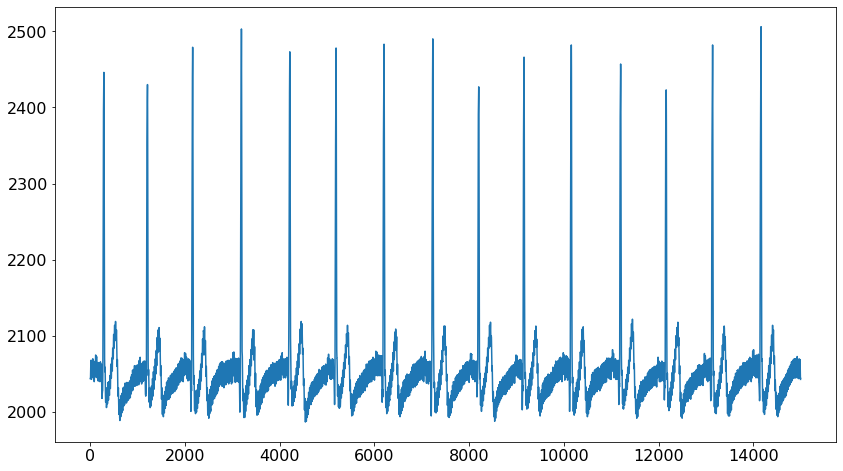

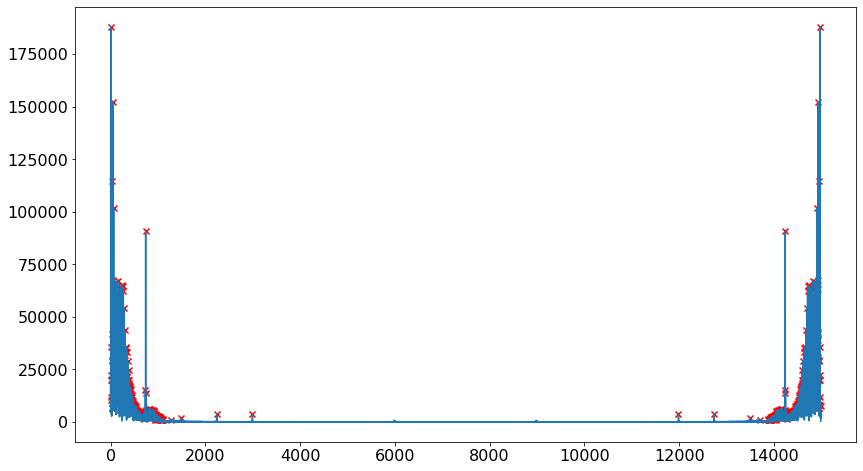

In [27]:
y_ecg = np.loadtxt('https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/NotebookExampleData/Week2/ecg.txt',skiprows=4)



## FFT and IFFT
## YOUR CODE HERE

# PLOT
## YOUR CODE HERE
plt.figure(figsize=(14,8))
plt.plot(y_ecg)
plt.figure(figsize=(14,8))
fft_res = np.abs(np.fft.fft(y_ecg))[10:];
plt.plot(fft_res)
peaks = find_peaks(fft_res, height=1000)
plt.scatter(peaks[0], peaks[1]['peak_heights'], marker='x', c='r')
plt.show()
# plt.plot(np.abs(np.fft.ifft(np.fft.fft(y_ecg))))

In [ ]:
T = t[1]-t[0]
N = t.size               

## PLOT FREQUENCY SPECTRUM

Okay, well that looks pretty good, but how well were we able to reconstruct the signal really? Check the correlation coefficient.

In [ ]:
np.corrcoef(abs(y_ecg), abs(y_ecg_recon))

## Okay, but that was a relatively periodic signal...
Let's try with a signal that doesn't look periodic at all!

(i.e. compare the raw signal to its fft, and reconstruct the raw signal by performing an inverse Fourier transform)

In [ ]:
import scipy.io.wavfile
from IPython.display import Audio

# original signal
(sample_rate, y_newt) = scipy.io.wavfile.read("./sounds/newt.wav")
t = np.arange(0, len(y_newt)/sample_rate, 1/sample_rate)

print('Sample rate: {} Hz'.format(sample_rate))

In [ ]:
## PLOT FREQUENCY SPECTRUM

T = t[1]-t[0]
N = t.size               

## YOUR CODE HERE

In [ ]:
# FFT, IFFT

## YOUR CODE HERE


# PLOT

## YOUR CODE HERE

In [ ]:
np.corrcoef(abs(y_newt), abs(y_newt_recon))

## Compare the original signal with the reconstructed signal by listening

In [ ]:
# Original signal
Audio(data=y_newt, rate=sample_rate)

In [ ]:
# Digitized signal
Audio(data=abs(y_newt_recon), rate=sample_rate)